## Imports

In [21]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.simplefilter("ignore")

## Reading Data, Cleaning Data, and Exploratory Data Analysis

In [3]:
data = pd.read_csv("data/raw/healthcare-dataset-stroke-data.csv")

In [4]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
print(data.shape)

(5110, 12)


In [7]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [10]:
data['age'] = data['age'].astype('int64')
data.drop('id', axis=1, inplace=True)
data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [11]:
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

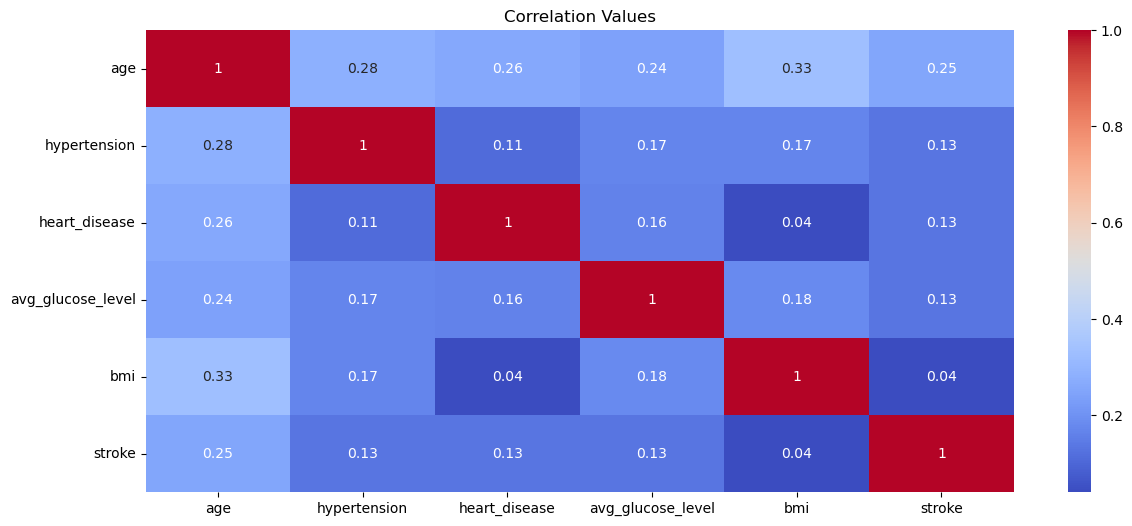

In [12]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(numeric_only=True).round(2), annot=True, cmap='coolwarm')
plt.title('Correlation Values')
plt.show()

Due to the presence of some null values in the bmi column within the dataset, I will impute the missing values in order to retain important data for the model

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42)
data['bmi'] = imp.fit_transform(data['bmi'].values.reshape(-1, 1))

In [14]:
data['bmi'].isna().sum()

0

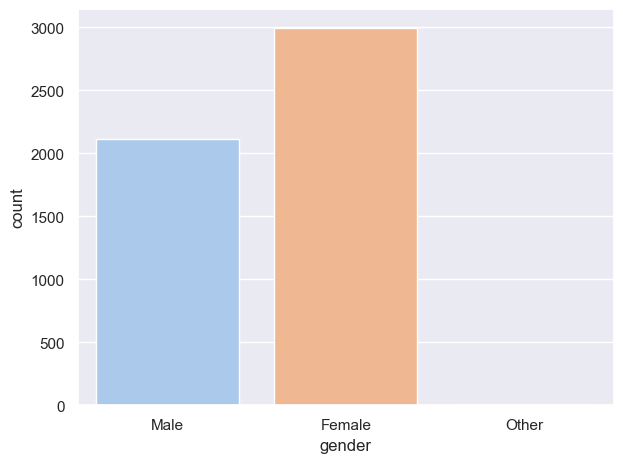

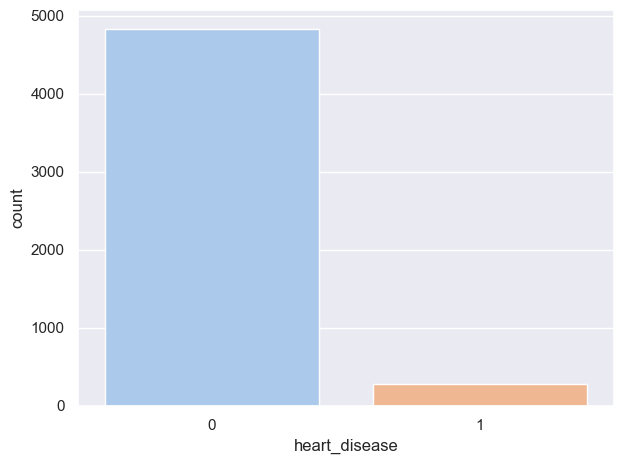

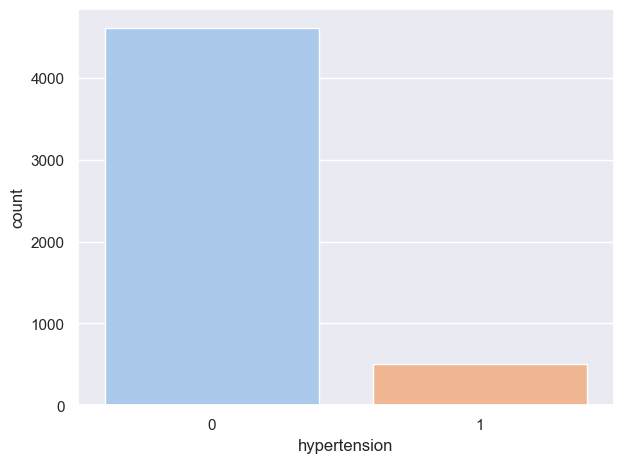

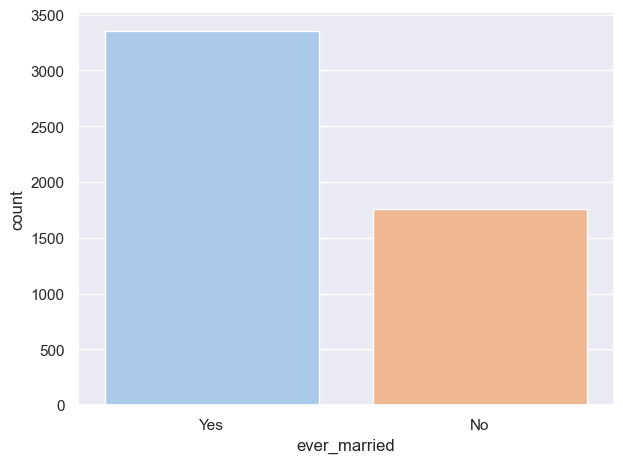

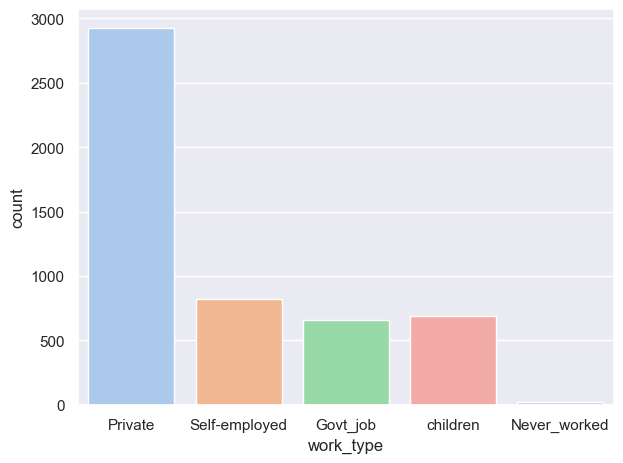

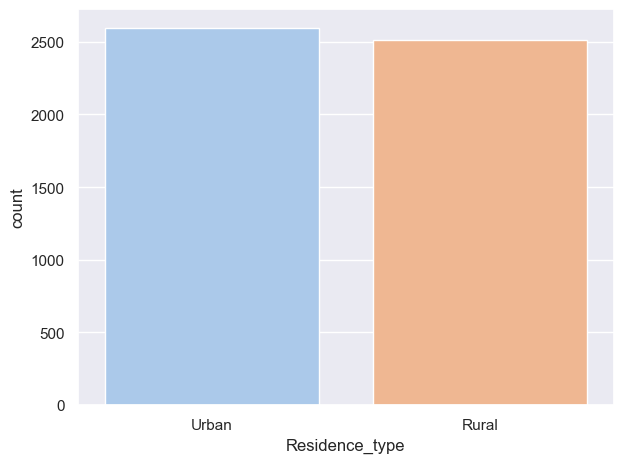

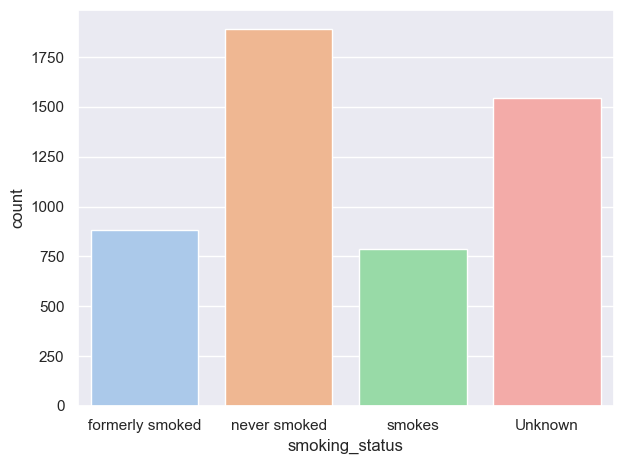

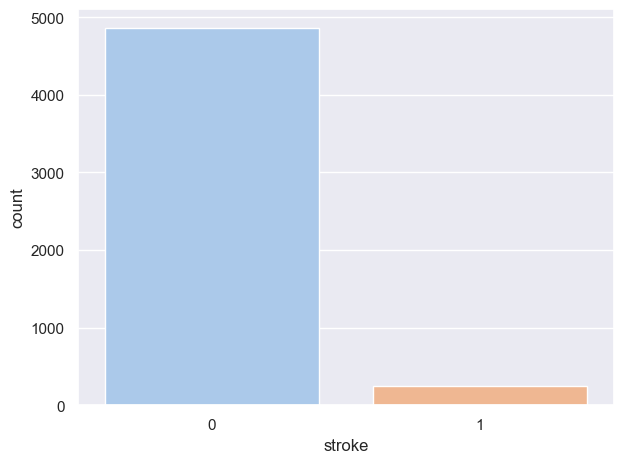

In [15]:
categorical_cols = ['gender', 'heart_disease', 'hypertension', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
sns.set_theme(style='darkgrid')
sns.set_palette('pastel')
for feature in categorical_cols:
    sns.countplot(data=data, x=feature)
    plt.tight_layout()
    plt.show()

This dataset is imbalanced, thus additional preprocessing steps must be taken to achieve better results on the model

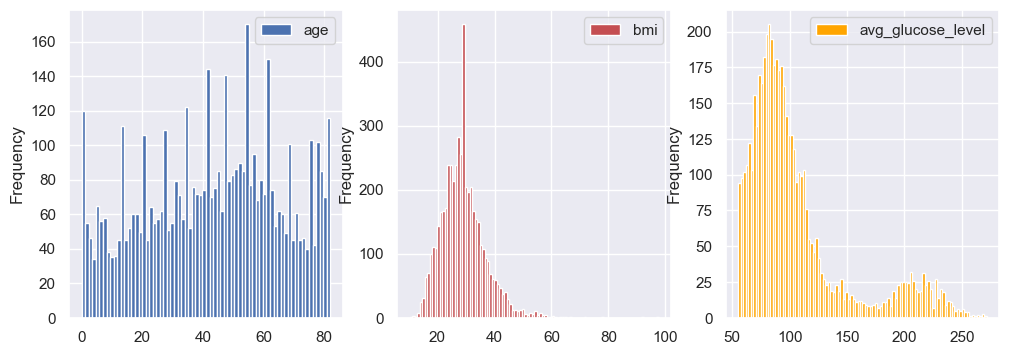

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

data.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0])
data.plot(kind="hist", y="bmi", bins=100, color="r", ax=axes[1])
data.plot(kind="hist", y="avg_glucose_level", bins=100, color="orange", ax=axes[2])

plt.show()

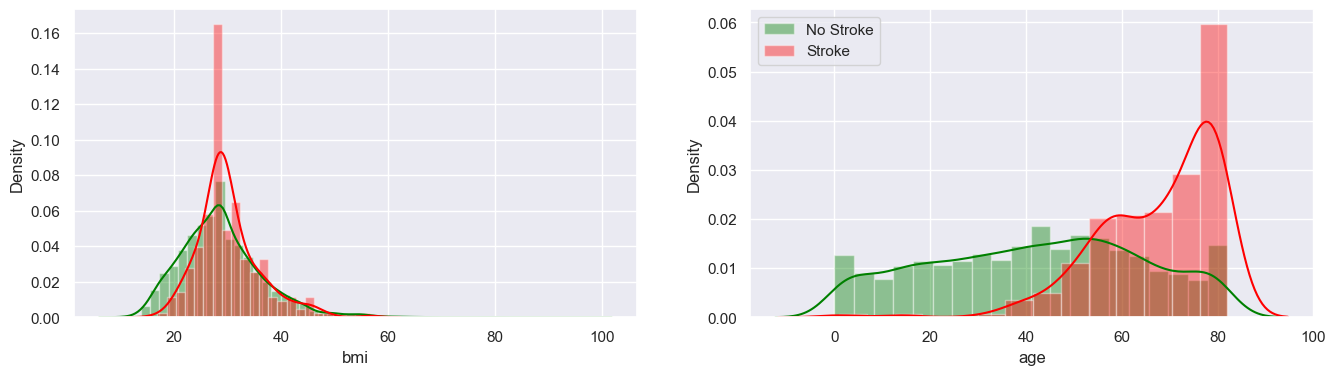

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(data[data['stroke'] == 0]["bmi"], color='green', label='No Stroke', ax=axes[0])
sns.distplot(data[data['stroke'] == 1]["bmi"], color='red', label='Stroke', ax=axes[0])
sns.distplot(data[data['stroke'] == 0]["age"], color='green', label='No Stroke', ax=axes[1])
sns.distplot(data[data['stroke'] == 1]["age"], color='red', label='Stroke', ax=axes[1])
plt.legend()
plt.show()

## Data Preprocessing

In [23]:
# Label encoding, standard scaler, SMOTE overfitting on train data only
# For models, try logistic regression, xgboost
# Standardizing
scaler = StandardScaler()

scale_cols = ['age', 'avg_glucose_level', 'bmi']

data[scale_cols] = scaler.fit_transform(data[scale_cols])
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.050950,0,1,Yes,Private,Urban,2.706375,1.001234e+00,formerly smoked,1
1,Female,0.785835,0,0,Yes,Self-employed,Rural,2.121559,4.393074e-16,never smoked,1
2,Male,1.625367,0,1,Yes,Private,Rural,-0.005028,4.685773e-01,never smoked,1
3,Female,0.255604,0,0,Yes,Private,Urban,1.437358,7.154182e-01,smokes,1
4,Female,1.581181,1,0,Yes,Self-employed,Rural,1.501184,-6.357112e-01,never smoked,1


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['gender'])
data['Marriage_Status'] = label_encoder.fit_transform(data['ever_married'])
data['Employment'] = label_encoder.fit_transform(data['work_type'])
data['Residency'] = label_encoder.fit_transform(data['Residence_type'])
data['Smoker'] = label_encoder.fit_transform(data['smoking_status'])

data = data.drop(['gender','ever_married','work_type','Residence_type', 'smoking_status'], axis=1)
data.head()

In [41]:
data.columns = data.columns.str.capitalize()
data[data.columns[-5:]] = data[data.columns[-5:]].astype('int64')
data.head()

,Age,Hypertension,Heart_disease,Avg_glucose_level,Bmi,Stroke,Sex,Marriage_status,Employment,Residency,Smoker
0,1.050950,0,1,2.706375,1.001234e+00,1,1,1,2,1,1
1,0.785835,0,0,2.121559,4.393074e-16,1,0,1,3,0,2
2,1.625367,0,1,-0.005028,4.685773e-01,1,1,1,2,0,2
3,0.255604,0,0,1.437358,7.154182e-01,1,0,1,2,1,3
4,1.581181,1,0,1.501184,-6.357112e-01,1,0,1,3,0,2


In [28]:
data.describe()

,Age,Hypertension,Heart_disease,Avg_glucose_level,Bmi,Stroke,Sex,Marriage_status,Employment,Residency,Smoker
count,5.110000e+03,5110.000000,5110.000000,5.110000e+03,5.110000e+03,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,-2.780989e-17,0.097456,0.054012,1.668594e-17,1.390495e-17,0.048728,0.414286,0.656164,2.167710,0.508023,1.376908
std,1.000098e+00,0.296607,0.226063,1.000098e+00,1.000098e+00,0.215320,0.493044,0.475034,1.090293,0.499985,1.071534
min,-1.909506e+00,0.000000,0.000000,-1.126958e+00,-2.415564e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.048579e-01,0.000000,0.000000,-6.383223e-01,-6.616944e-01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,7.886017e-02,0.000000,0.000000,-3.149945e-01,-6.407951e-02,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000
75%,7.858347e-01,0.000000,0.000000,1.754080e-01,5.075521e-01,0.000000,1.000000,1.000000,3.000000,1.000000,2.000000
max,1.713739e+00,1.000000,1.000000,3.657145e+00,8.926127e+00,1.000000,2.000000,1.000000,4.000000,1.000000,3.000000


In [30]:
data.shape

(5110, 11)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                5110 non-null   float64
 1   Hypertension       5110 non-null   int64  
 2   Heart_disease      5110 non-null   int64  
 3   Avg_glucose_level  5110 non-null   float64
 4   Bmi                5110 non-null   float64
 5   Stroke             5110 non-null   int64  
 6   Sex                5110 non-null   int64  
 7   Marriage_status    5110 non-null   int64  
 8   Employment         5110 non-null   int64  
 9   Residency          5110 non-null   int64  
 10  Smoker             5110 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 439.3 KB


In [43]:
data.to_csv('data/processed/processed.csv')

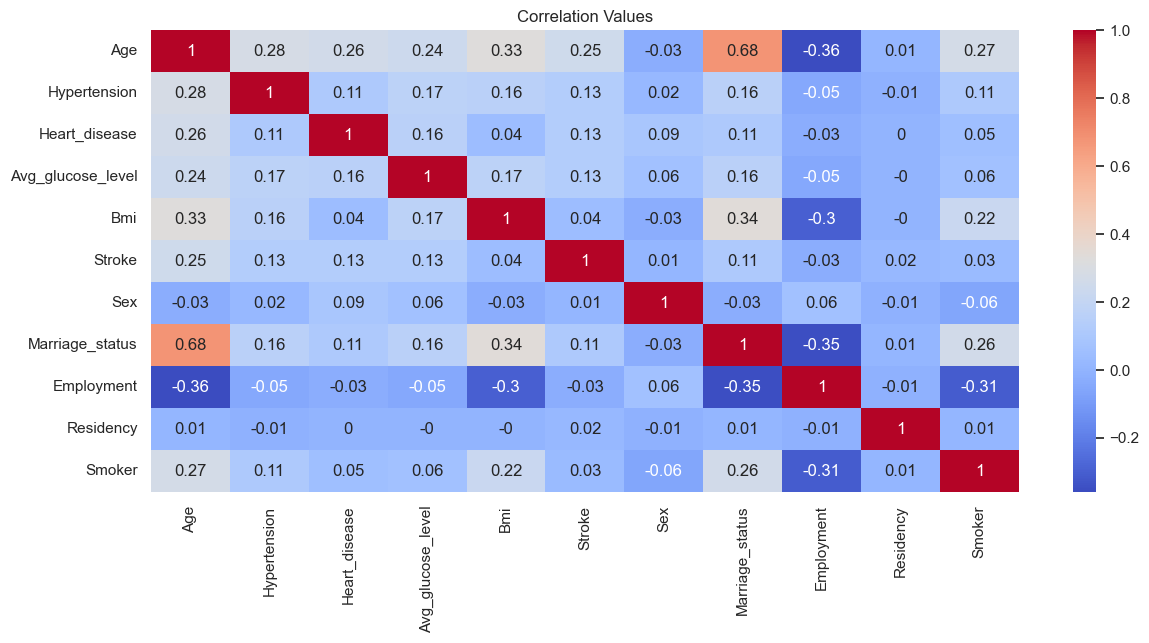

In [44]:
# Correlation Matrix to Identify Relationships After Preprocessing
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(numeric_only=True).round(2), annot=True, cmap='coolwarm')
plt.title('Correlation Values')
plt.show()

# Predictive Modelling
### Splitting Data

In [48]:
X = data.drop('Stroke', axis=1)
y = data['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("Finished training and testing split.")

Finished training and testing split.
